In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from IPython.display import Audio, clear_output
import os
from scipy.io import wavfile
import sys
sys.path.append("../..")
from sampling_filter import gaussian_tools, fourier_core


First, load a track

In [3]:
data_path = os.path.join(os.getenv("HOME"), "quantum_music_files/light_of_ages.wav")
song_samplerate, song_data = wavfile.read(data_path)
song_data = song_data.T

/var/folders/mq/fms8l94x0db50dyyzjvjh6_80000gn/T/ipykernel_5403/1634036827.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  song_samplerate, song_data = wavfile.read(data_path)


In [4]:
Audio(song_data, rate=song_samplerate)
#clear_output()

Plot the spectrum

In [5]:
data_coeffs = fourier_core.fourier_series_coeffs(song_data, axes_from=1)

In [6]:
import importlib
importlib.reload(fourier_core)
zero_coeff, positive_coeffs, nyquist_term, negative_coeffs = fourier_core.unpack_coeffs(data_coeffs)
all_freqs = np.fft.fftfreq(data_coeffs.shape[-1], d=1/song_samplerate)
_, positive_freqs, _, _ = fourier_core.unpack_coeffs(all_freqs)
k_to_hz = positive_freqs[0]

Text(0, 0.5, 'Amplitude')

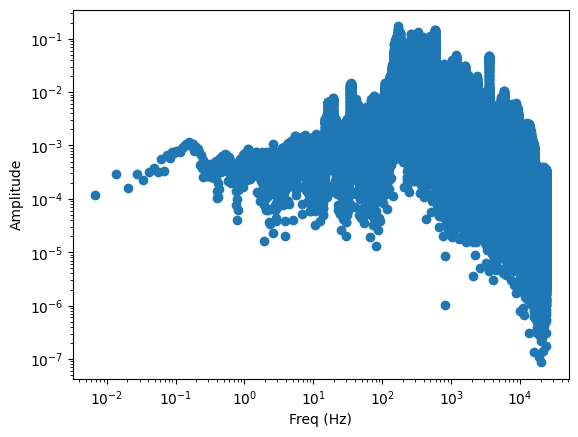

In [7]:
fig, axs = plt.subplots()
axs.scatter(positive_freqs, np.abs(positive_coeffs[0, :]))
axs.set_yscale("log")
axs.set_xscale("log")
axs.set_xlabel("Freq (Hz)")
axs.set_ylabel("Amplitude")

Define a noise PSD. Here we implement a 1/f-type PSD, corresponding to a coherent state

In [8]:
mode_order = np.argsort(np.abs(positive_coeffs), axis=-1)[:, ::-1]
most_powerful_freq = np.max(mode_order[0, 0])
most_powerful_freq_hz = np.max(mode_order[:, 0]) * k_to_hz
highest_mode_power = np.abs(positive_coeffs[0, :])[most_powerful_freq]

In [9]:
def psd_fn_1_f(k_vals, scale_const=1):
    freq_vals = k_vals * k_to_hz
    scaled_freqs = freq_vals/most_powerful_freq_hz
    return ((1/np.sqrt(scaled_freqs)) * scale_const * highest_mode_power)**2

We need a source of unit variance gaussian noise. This is where the quantum computer could come in. Here, we just use a classical sampler

In [10]:
source_of_unit_var_noise = lambda x: np.random.normal(size=x)

Compute the total variance and generate the samples from the source of unit variance noise

In [11]:
relative_noise_power = 0.02
var = np.sum(psd_fn_1_f(positive_freqs, relative_noise_power))
samples = gaussian_tools.sample_scaled_shifted_gaussians(np.size(song_data), [var], [0], source_of_unit_var_noise).reshape(song_data.shape)
samples = np.transpose(samples.T - np.mean(samples, axis=-1)) # get rid of the mean to avoid biasing L+R channels differently

create a lowpass filter

Text(0, 0.5, 'Gain (dB)')

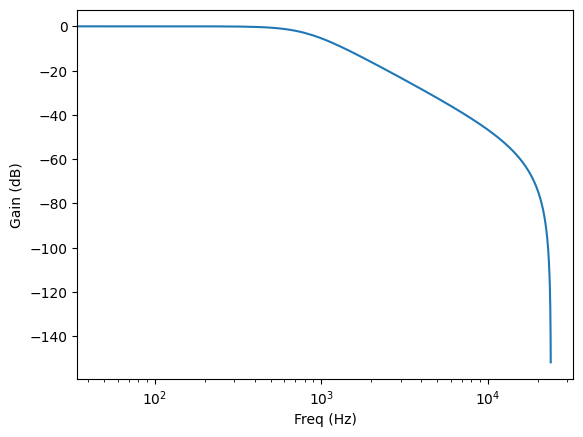

In [12]:
order = 2 # order * 10 dB/decade falloff
cutoff_freq = 800 # cutoff freq in Hz
filter_b, filter_a = scipy.signal.butter(order, cutoff_freq, 'low', fs=song_samplerate)
w, h = scipy.signal.freqz(filter_b, filter_a)
fig, axs = plt.subplots()
axs.plot(w * song_samplerate/(2 * np.pi), 20 * np.log10(abs(h)))
axs.set_xscale("log")
axs.set_xlabel("Freq (Hz)")
axs.set_ylabel("Gain (dB)")

apply just the filter to the song to see what that sounds like

In [13]:
filtered_song = scipy.signal.lfilter(filter_b, filter_a, song_data, axis=-1)

In [14]:
Audio(filtered_song.astype(np.uint8), rate=song_samplerate)
#clear_output()

now we compute the noise contribution. Our samples are of white noise, and we convolve them with the original song, which yeilds noise with a PSD shaped by the spectrum of the song.

Text(0.5, 0.98, 'Noise PSD')

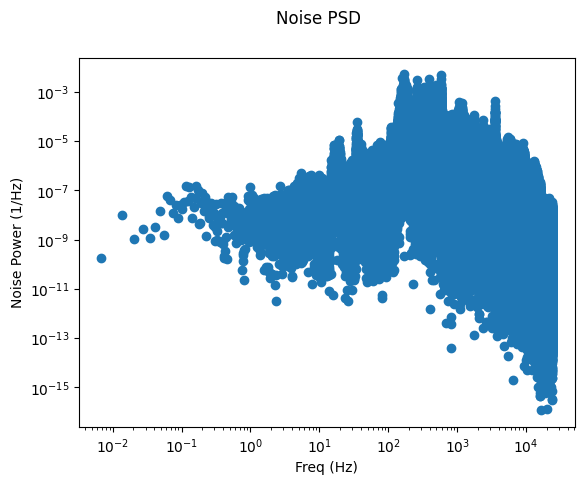

In [15]:
sample_coeffs = fourier_core.fourier_series_coeffs(samples, axes_from=1)
noise_part = np.real(np.fft.ifft(data_coeffs * sample_coeffs, norm="forward", axis=-1))
_, noise_coeffs, _, _ = fourier_core.unpack_coeffs(fourier_core.fourier_series_coeffs(noise_part, axes_from=1))
fig, axs = plt.subplots()
axs.scatter(positive_freqs, np.abs(noise_coeffs[0, :])**2)
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_xlabel("Freq (Hz)")
axs.set_ylabel("Noise Power (1/Hz)")
fig.suptitle("Noise PSD")

Now sum it all up to get the final result

In [16]:
final_song = filtered_song + 2 * noise_part
final_song = final_song * (final_song > 0)
final_song = final_song.astype(np.uint8)
Audio(final_song, rate=song_samplerate)
#clear_output()

In [17]:
out_path = os.path.join(os.getenv("HOME"), "quantum_music_files/light_of_ages_quantum_lowpass.wav")
song_samplerate, song_data = wavfile.write(out_path, song_samplerate, np.transpose(final_song))

TypeError: cannot unpack non-iterable NoneType object